In [1]:
pip install moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 9.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for imageio_ffmpeg>=0.2.0 from https://files.pythonhosted.org/packages/1a/98/3df1d8dd8f2c121b6c588b1e0d604f36592d56df9c41fb155ed546c6a5ed/imageio_ffmpeg-0.4.9-py3-none-manylinux2010_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 48.5 MB/s eta 0:00:00:00:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110721 sha256=829a05866a97cb0cc937dbe0a4a72211f95e5d3fd926e11fa02d26af597cee9e
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are

In [2]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
seed_constant = 3
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

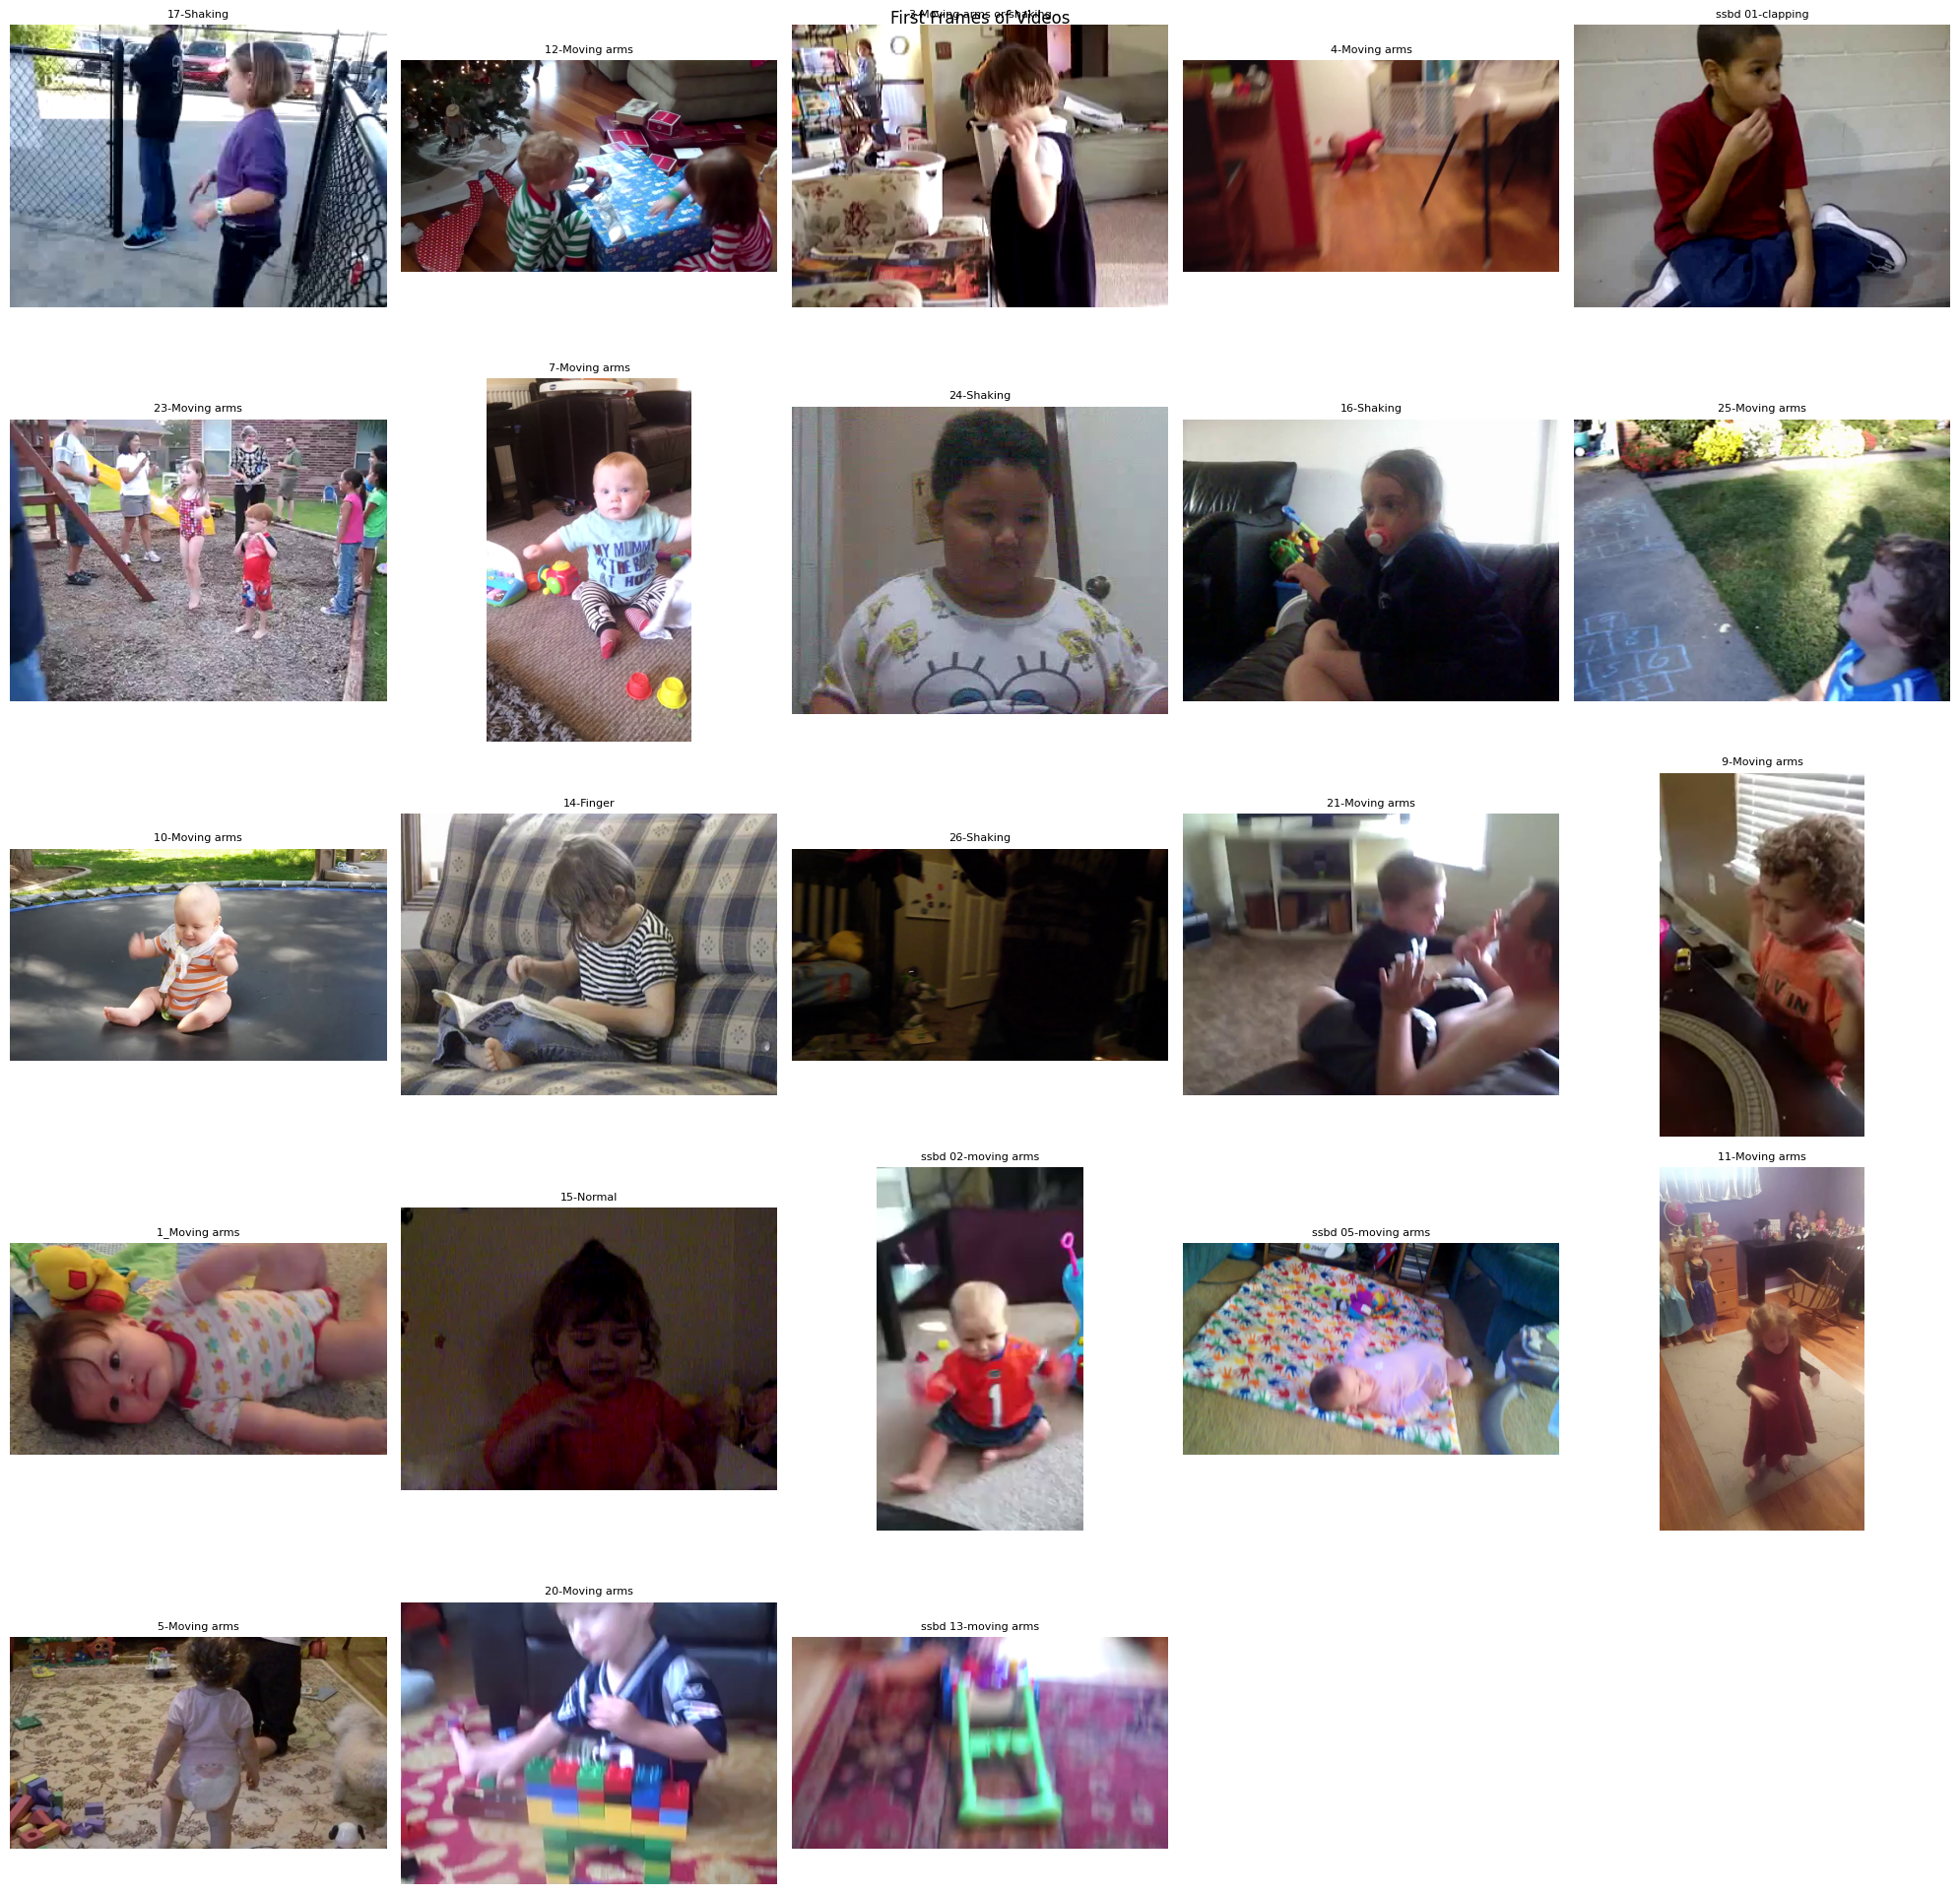

In [4]:
# Initialize counter and video count
counter = 1
total_videos = 0

base_directory = '/kaggle/input/ssbd-videos-2/videos'
# Get the list of all files in the base_directory
all_files = [f for f in os.listdir(base_directory) if os.path.isfile(os.path.join(base_directory, f))]

# Filter out video files (assuming .mp4, .avi, .mov file types, add other types if needed)
video_files = [f for f in all_files if f.endswith(('.mp4', '.avi', '.mov'))]
total_videos = len(video_files)

# Calculate grid size for subplots
grid_size = int(total_videos**0.5) + 1  # Square root to determine grid dimensions
plt.figure(figsize=(20, 20))

# Process and display each video's first frame
for video in video_files:
    video_path = os.path.join(base_directory, video)
    video_reader = cv2.VideoCapture(video_path)

    if video_reader.isOpened():
        _, bgr_frame = video_reader.read()
        video_reader.release()

        if bgr_frame is not None:
            video_name = video.split('.')[0]
            rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
            plt.subplot(grid_size, grid_size, counter)
            plt.imshow(rgb_frame)
            plt.title(video_name, fontsize=8)
            plt.axis('off')
            counter += 1
        else:
            print(f"Failed to read frame from {video_path}")
    else:
        print(f"Failed to open video {video_path}")

plt.tight_layout()
plt.suptitle('First Frames of Videos')
plt.show()

In [5]:
video_files = []

# List all files in the base directory and add them to the video_files list if they are files
video_files = [os.path.join(base_directory, f) for f in os.listdir(base_directory) if os.path.isfile(os.path.join(base_directory, f))]

print(video_files)

['/kaggle/input/ssbd-videos-2/videos/17-Shaking.mp4', '/kaggle/input/ssbd-videos-2/videos/12-Moving arms.mp4', '/kaggle/input/ssbd-videos-2/videos/3-Moving arms or shaking.mp4', '/kaggle/input/ssbd-videos-2/videos/4-Moving arms.mp4', '/kaggle/input/ssbd-videos-2/videos/ssbd 01-clapping.mp4', '/kaggle/input/ssbd-videos-2/videos/23-Moving arms.mp4', '/kaggle/input/ssbd-videos-2/videos/7-Moving arms.mp4', '/kaggle/input/ssbd-videos-2/videos/24-Shaking.mp4', '/kaggle/input/ssbd-videos-2/videos/16-Shaking.mp4', '/kaggle/input/ssbd-videos-2/videos/25-Moving arms.mp4', '/kaggle/input/ssbd-videos-2/videos/10-Moving arms.mp4', '/kaggle/input/ssbd-videos-2/videos/14-Finger.mp4', '/kaggle/input/ssbd-videos-2/videos/26-Shaking.mp4', '/kaggle/input/ssbd-videos-2/videos/21-Moving arms.mp4', '/kaggle/input/ssbd-videos-2/videos/9-Moving arms.mp4', '/kaggle/input/ssbd-videos-2/videos/1_Moving arms.mp4', '/kaggle/input/ssbd-videos-2/videos/15-Normal.mp4', '/kaggle/input/ssbd-videos-2/videos/ssbd 02-movi

In [6]:
import cv2
import os

# Assuming video_files is a list of video file paths
video_files = [os.path.join(base_directory, f) for f in os.listdir(base_directory) if os.path.isfile(os.path.join(base_directory, f))]

def get_video_fps(video_path):
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    video.release()
    return fps

# Iterate through the list of video file paths and print their fps
for video_path in video_files:
    fps = get_video_fps(video_path)
    print(f"Video: {video_path}, FPS: {fps}")

Video: /kaggle/input/ssbd-videos-2/videos/17-Shaking.mp4, FPS: 15.0
Video: /kaggle/input/ssbd-videos-2/videos/12-Moving arms.mp4, FPS: 30.0
Video: /kaggle/input/ssbd-videos-2/videos/3-Moving arms or shaking.mp4, FPS: 23.954
Video: /kaggle/input/ssbd-videos-2/videos/4-Moving arms.mp4, FPS: 30.0
Video: /kaggle/input/ssbd-videos-2/videos/ssbd 01-clapping.mp4, FPS: 24.12082514734774
Video: /kaggle/input/ssbd-videos-2/videos/23-Moving arms.mp4, FPS: 30.0
Video: /kaggle/input/ssbd-videos-2/videos/7-Moving arms.mp4, FPS: 28.825915871030716
Video: /kaggle/input/ssbd-videos-2/videos/24-Shaking.mp4, FPS: 14.767
Video: /kaggle/input/ssbd-videos-2/videos/16-Shaking.mp4, FPS: 29.6752
Video: /kaggle/input/ssbd-videos-2/videos/25-Moving arms.mp4, FPS: 25.0
Video: /kaggle/input/ssbd-videos-2/videos/10-Moving arms.mp4, FPS: 30.0
Video: /kaggle/input/ssbd-videos-2/videos/14-Finger.mp4, FPS: 30.0
Video: /kaggle/input/ssbd-videos-2/videos/26-Shaking.mp4, FPS: 29.970200085142615
Video: /kaggle/input/ssbd-v

In [7]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 15

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = '/kaggle/input/ssbd-videos/videos'

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
# CLASSES_LIST = ['nothing', 'hand_shaking', 'moving_arms']

In [8]:
def timestamp_to_frame(timestamp, standard_fps):
      parts = timestamp.split(':')
      if len(parts) == 2:
          # Format is MM:SS
          m, s = map(int, parts)
          total_seconds = m * 60 + s
      elif len(parts) == 3:
          # Format is HH:MM:SS
          h, m, s = map(int, parts)
          total_seconds = h * 3600 + m * 60 + s
      else:
          raise ValueError(f"Invalid timestamp format: {timestamp}")

      return int(total_seconds * standard_fps)

In [9]:
def classify_frames(video_path, action_intervals, standard_fps=15, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH):
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # print(f"Processing video: {video_path}")
    # print(f"Total frames: {total_frames}")

    action_frames = {action: [] for action in action_intervals}
    action_frames['nothing'] = []
    frame_counts = {action: 0 for action in action_intervals}
    frame_counts['nothing'] = 0

    for frame_num in range(total_frames):
        success, frame = video.read()
        if not success:
            break

        resized_frame = cv2.resize(frame, (image_width, image_height))
        normalized_frame = resized_frame / 255.0

        label = 'nothing'
        for action, intervals in action_intervals.items():
            for start_time, end_time in intervals:
                start_frame = timestamp_to_frame(start_time, standard_fps)
                end_frame = timestamp_to_frame(end_time, standard_fps)
                if start_frame <= frame_num <= end_frame:
                    label = action
                    break
            if label != 'nothing':
                break

        action_frames[label].append(normalized_frame)
        frame_counts[label] += 1

    # print(f"Frame counts for {video_path}: {frame_counts}")
    video.release()
    return action_frames

In [10]:
video_timestamps = {
    '/kaggle/input/ssbd-videos/videos/10-Moving arms.mp4': {
        'moving_arms': [('00:00', '00:03'),
                        ('00:03', '00:05'),
                        ('00:16', '00:19'),
                        ('00:21', '00:23'),
                        ('00:25', '00:27'),
                        ('00:30', '00:32'),
                        ('00:39', '00:43'),
                        ('01:01', '01:02'),
                        ('01:09', '01:13'),
                        ('01:14', '01:16'),
                        ('01:30', '01:32'),
                        ('01:39', '01:41')]
    },
    '/kaggle/input/ssbd-videos/videos/11-Moving arms.mp4':{
        'hand_shaking':[('00:00', '00:02')]
    },
    '/kaggle/input/ssbd-videos/videos/12-Moving arms.mp4':{
        'hand_shaking':[('00:07', '00:09'), ('00:14', '00:19'), ('00:34', '00:36')]
    },
    '/kaggle/input/ssbd-videos/videos/16-Shaking.mp4':{
        'hand_shaking':[('00:03', '00:11'), ('00:12', '00:15'), ('00:15', '00:30'), ('00:31', '00:33'), ('00:42', '00:46'),
                        ('00:48', '00:51'), ('01:03', '01:11'), ('01:14', '01:17'), ('01:18', '01:25'), ('01:28', '01:31'),
                        ('01:33', '01:39'), ('01:44', '01:57'), ('01:59', '02:09'), ('02:11', '02:36'), ('02:41', '02:42'), ('02:43', '02:44')]
    },
    '/kaggle/input/ssbd-videos/videos/17-Shaking.mp4':{
        'hand_shaking':[('00:05', '00:07'), ('00:40', '00:44')]
    },
    '/kaggle/input/ssbd-videos/videos/1_Moving arms.mp4':{
        'moving_arms':[('00:38', '00:41'), ('01:05', '01:08'), ('01:38', '01:40'), ('01:50', '01:55'), ('02:16', '02:19')]
    },
    '/kaggle/input/ssbd-videos/videos/20-Moving arms.mp4':{
        'moving_arms':[('00:04', '00:08'), ('00:28', '00:30'), ('00:41', '00:43'), ('00:46', '00:50')]
    },
    '/kaggle/input/ssbd-videos/videos/21-Moving arms.mp4':{
        'moving_arms':[('02:58', '03:12'), ('03:26', '03:39')]
    },
    '/kaggle/input/ssbd-videos/videos/23-Moving arms.mp4':{
        'hand_shaking':[('00:00', '00:02'), ('00:07', '00:09'), ('00:14', '00:16')]
    },
    '/kaggle/input/ssbd-videos/videos/24-Shaking.mp4':{
        'hand_shaking':[('00:02', '00:06'), ('00:17', '00:18'), ('00:23', '00:26'), ('00:32', '00:36'), ('00:42', '00:50'),
                        ('00:52', '00:56'), ('01:00', '01:01'), ('01:03', '01:07'), ('01:11', '01:14'), ('01:15', '01:19'),
                        ('01:20', '01:25'), ('01:26', '01:30'), ('01:34', '01:42'), ('01:44', '01:45'), ('01:51', '02:00')]
    },
    '/kaggle/input/ssbd-videos/videos/25-Moving arms.mp4':{
        'hand_shaking':[('00:08', '00:10'), ('00:11', '00:14')],
        'moving_arms':[('00:21', '00:22'), ('00:33', '00:34')]
    },
    '/kaggle/input/ssbd-videos/videos/26-Shaking.mp4':{
        'hand_shaking':[('00:05', '00:08'), ('00:11', '00:12')]
    },
    '/kaggle/input/ssbd-videos/videos/3-Moving arms or shaking.mp4':{
        'hand_shaking':[('00:00', '00:04'), ('00:13', '00:15'), ('00:18', '00:19'), ('00:22', '00:27'), ('00:33', '00:36'),
                        ('00:42', '00:46'), ('00:50', '00:54'), ('00:56', '00:57'), ('01:06', '01:07'), ('01:09', '01:11'),
                        ('01:12', '01:15'), ('01:16', '01:18'), ('01:19', '01:23'), ('01:31', '01:32'), ]
    },
    '/kaggle/input/ssbd-videos/videos/4-Moving arms.mp4':{
        'moving_arms':[('00:03', '00:09')]
    },
    '/kaggle/input/ssbd-videos/videos/5-Moving arms.mp4':{
        'hand_shaking':[('00:04', '00:08'), ('00:09', '00:12')]
    },
    '/kaggle/input/ssbd-videos/videos/7-Moving arms.mp4':{
        'moving_arms':[('00:06', '00:08'), ('00:09', '00:11'), ('00:15', '00:18'), ('00:19', '00:21')]
    },
    '/kaggle/input/ssbd-videos/videos/9-Moving arms.mp4':{
        'hand_shaking':[('00:00', '00:03'), ('00:05', '00:07'), ('00:18', '00:27')]
    },
    '/kaggle/input/ssbd-videos/videos/ssbd 02-moving arms.mp4':{
        'moving_arms':[('00:00', '00:03'), ('00:12', '00:16'), ('00:20', '00:23'), ('00:29', '00:32')]
    },
    '/kaggle/input/ssbd-videos/videos/ssbd 05-moving arms.mp4':{
        'moving_arms':[('00:03', '00:07'), ('00:08', '00:10'), ('00:11', '00:12'), ('00:13', '00:15'), ]
    },
    '/kaggle/input/ssbd-videos/videos/ssbd 13-moving arms.mp4':{
        'moving_arms':[('00:19', '00:22'), ('00:40', '00:46'), ('00:48', '00:53'), ]
    }
}

In [11]:
def create_dataset(video_timestamps, sequence_length=SEQUENCE_LENGTH, standard_fps=15, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH):
    features = []
    labels = []
    video_files_paths = []

    # Explicitly define CLASSES_LIST
    CLASSES_LIST = ['hand_shaking', 'nothing', 'moving_arms']
    label_mapping = {label: idx for idx, label in enumerate(CLASSES_LIST)}

    sequence_counts = {label: 0 for label in CLASSES_LIST}  # Initialize sequence count for each label

    for video_path, actions in video_timestamps.items():
        classified_frames = classify_frames(video_path, actions, standard_fps, image_height, image_width)

        for label, frames in classified_frames.items():
            for i in range(0, len(frames), sequence_length):
                sequence = frames[i:i + sequence_length]

                # Ensure the sequence is complete
                if len(sequence) == sequence_length:
                    features.append(sequence)
                    labels.append(label_mapping[label])
                    video_files_paths.append(video_path)
                    sequence_counts[label] += 1  # Count each complete sequence

    features = np.asarray(features)
    labels = np.array(labels)

    print("CLASSES_LIST:", CLASSES_LIST)
    print("Label Mapping:", label_mapping)

    # Print sequence count for each class
    for label, count in sequence_counts.items():
        print(f"Total sequences in class '{label}': {count}")

    return features, labels, video_files_paths, CLASSES_LIST

In [12]:
from sklearn.model_selection import train_test_split

video_paths = list(video_timestamps.keys())

# Split the video paths into training and test sets
train_videos, test_videos = train_test_split(video_paths, test_size=0.2, random_state=0)

# Create two separate dictionaries for training and test sets
train_timestamps = {video: video_timestamps[video] for video in train_videos}
test_timestamps = {video: video_timestamps[video] for video in test_videos}

# Generate datasets for training and testing
train_features, train_labels, train_video_files_paths, CLASSES_LIST = create_dataset(train_timestamps)
test_features, test_labels, test_video_files_paths, _ = create_dataset(test_timestamps)

print(CLASSES_LIST)

CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
['hand_shaking', 'nothing', 'moving_arms']


In [13]:
frames_per_class = {label: [] for label in CLASSES_LIST}

for video_path, actions in video_timestamps.items():
    classified_frames = classify_frames(video_path, actions)
    for label, frames in classified_frames.items():
        frames_per_class[label].extend(frames)

for label in CLASSES_LIST:
    print(f"Total frames in class '{label}': {len(frames_per_class[label])}")

Total frames in class 'hand_shaking': 4034
Total frames in class 'nothing': 34339
Total frames in class 'moving_arms': 2095


In [14]:
from collections import Counter

overlap = set(train_videos).intersection(set(test_videos))
print(f"Number of overlapping videos: {len(overlap)}")
assert len(overlap) == 0, "Overlap detected between training and test sets"

total_videos = len(video_paths)
num_train = len(train_videos)
num_test = len(test_videos)

print(f"Total number of videos: {total_videos}")
print(f"Number in training set: {num_train} ({num_train/total_videos*100:.2f}%)")
print(f"Number in test set: {num_test} ({num_test/total_videos*100:.2f}%)")

def get_class_distribution(video_set, video_timestamps):
    class_distribution = Counter()
    for video in video_set:
        for action in video_timestamps[video].keys():
            class_distribution[action] += 1
    return class_distribution

train_distribution = get_class_distribution(train_videos, video_timestamps)
test_distribution = get_class_distribution(test_videos, video_timestamps)

print("Training set class distribution:", train_distribution)
print("Test set class distribution:", test_distribution)

print("Sample training videos:", train_videos[:5])
print("Sample test videos:", test_videos[:5])

Number of overlapping videos: 0
Total number of videos: 20
Number in training set: 16 (80.00%)
Number in test set: 4 (20.00%)
Training set class distribution: Counter({'hand_shaking': 9, 'moving_arms': 8})
Test set class distribution: Counter({'moving_arms': 2, 'hand_shaking': 2})
Sample training videos: ['/kaggle/input/ssbd-videos/videos/25-Moving arms.mp4', '/kaggle/input/ssbd-videos/videos/ssbd 02-moving arms.mp4', '/kaggle/input/ssbd-videos/videos/20-Moving arms.mp4', '/kaggle/input/ssbd-videos/videos/4-Moving arms.mp4', '/kaggle/input/ssbd-videos/videos/17-Shaking.mp4']
Sample test videos: ['/kaggle/input/ssbd-videos/videos/ssbd 05-moving arms.mp4', '/kaggle/input/ssbd-videos/videos/11-Moving arms.mp4', '/kaggle/input/ssbd-videos/videos/ssbd 13-moving arms.mp4', '/kaggle/input/ssbd-videos/videos/23-Moving arms.mp4']


In [15]:
def augment_sequence(sequence):
    augmentation_choice = random.choice(['flip', 'rotate', 'translate', 'scale'])

    if augmentation_choice == 'flip':
        # Horizontal flip
        return [cv2.flip(frame, 1) for frame in sequence]
    elif augmentation_choice == 'rotate':
        # Random rotation between -10 to 10 degrees
        angle = random.uniform(-10, 10)
        M = cv2.getRotationMatrix2D((sequence[0].shape[1] // 2, sequence[0].shape[0] // 2), angle, 1)
        return [cv2.warpAffine(frame, M, (frame.shape[1], frame.shape[0])) for frame in sequence]
    elif augmentation_choice == 'translate':
        # Random translation
        tx = random.uniform(-10, 10)
        ty = random.uniform(-10, 10)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        return [cv2.warpAffine(frame, M, (frame.shape[1], frame.shape[0])) for frame in sequence]
    elif augmentation_choice == 'scale':
        # Random scaling
        scale_factor = random.uniform(0.9, 1.1)
        M = cv2.getRotationMatrix2D((sequence[0].shape[1] // 2, sequence[0].shape[0] // 2), 0, scale_factor)
        return [cv2.warpAffine(frame, M, (frame.shape[1], frame.shape[0])) for frame in sequence]

In [16]:
def plot_metric(training_history, metric, test_metric, plot_name):
    # Get training metric values
    training_metric_values = training_history.history[metric]
    epochs = range(len(training_metric_values))

    # Plot training metric
    plt.plot(epochs, training_metric_values, 'blue', label=f'Training {metric.capitalize()}')

    # Plot testing metric as a horizontal line
    plt.axhline(y=test_metric, color='red', linestyle='--', label=f'Test {metric.capitalize()}')

    # Add title and legend to the plot
    plt.title(plot_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

In [17]:
def balance_dataset(features, labels, class_limit=300):
    decoded_labels = np.argmax(labels, axis=1)
    class_sequences = [[] for _ in range(len(CLASSES_LIST))]

    # Separate features by class
    for i, label in enumerate(decoded_labels):
        class_sequences[label].append(features[i])

    # Balancing logic
    for class_index, sequences in enumerate(class_sequences):
        current_count = len(sequences)
        if current_count > class_limit:
            class_sequences[class_index] = random.sample(sequences, class_limit)
        else:
            augmented_sequences = []
            while len(augmented_sequences) + current_count < class_limit:
                sequence_to_augment = random.choice(sequences)
                augmented_sequences.append(augment_sequence(sequence_to_augment))

            class_sequences[class_index].extend(augmented_sequences)

    # Combine and shuffle the balanced dataset
    balanced_features = np.concatenate(class_sequences)
    balanced_labels = np.concatenate([[to_categorical(i, num_classes=len(CLASSES_LIST)) for _ in range(len(class_sequences[i]))] for i in range(len(CLASSES_LIST))])

    combined = list(zip(balanced_features, balanced_labels))
    random.shuffle(combined)
    balanced_features, balanced_labels = zip(*combined)
    return np.array(balanced_features), np.array(balanced_labels)

In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, TimeDistributed, Flatten, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import itertools
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

def create_LRCN_ResNet_model(lstm_units, dropout_rate, learning_rate, num_unfrozen_layers=None):
    input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

    # Decide how many layers to unfreeze
    if num_unfrozen_layers is not None:
        for layer in base_model.layers[:-num_unfrozen_layers]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False

    model_input = Input(shape=input_shape)
    time_distributed = TimeDistributed(base_model)(model_input)
    time_distributed = TimeDistributed(Flatten())(time_distributed)

    # LSTM layer
    lstm = LSTM(lstm_units)(time_distributed)
    lstm = Dropout(dropout_rate)(lstm)

    # Output layer
    output = Dense(len(CLASSES_LIST), activation='softmax')(lstm)

    model = Model(inputs=model_input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=["accuracy"])
    model.summary()
    return model

In [ ]:
hyperparameter_grid = {
    'lstm_units': [64],
    'dropout_rate': [0.4],
    'learning_rate': [0.001, 0.0001],
    'num_unfrozen_layers': [None, 5]
}

def get_all_hyperparameter_combinations(hyperparameter_grid):
    keys, values = zip(*hyperparameter_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    random.shuffle(combinations)
    return combinations

In [ ]:
def count_sequences_per_class(labels, class_list):
    label_counts = Counter(labels)
    class_sequence_counts = {class_name: label_counts.get(i, 0) for i, class_name in enumerate(class_list)}
    return class_sequence_counts

# Count the number of sequences for each class in the training set
train_sequence_counts = count_sequences_per_class(train_labels, CLASSES_LIST)
print("Number of sequences per class in the training set:", train_sequence_counts)

# Count the number of sequences for each class in the test set
test_sequence_counts = count_sequences_per_class(test_labels, CLASSES_LIST)
print("Number of sequences per class in the test set:", test_sequence_counts)

In [ ]:
len(train_videos)

In [ ]:
from keras.callbacks import EarlyStopping

# Split the video paths into training, validation, and test sets
video_paths = list(video_timestamps.keys())
train_videos, test_videos = train_test_split(video_paths, test_size=0.2, random_state=0)

# Set up KFold for the training set
num_folds = 3
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)

best_hyperparams_LRCN = None
best_val_accuracy_LRCN = 0
best_val_loss_LRCN = None
best_hyperparams_LRCN_result = {
    'training_loss' : [],
    'training_accuracy': [],
    'validation_loss': [],
    'validation_accuracy': []
}

epochs = 25
batch_size = 16

# Assuming get_all_hyperparameter_combinations and other necessary methods are defined
for hyperparams in get_all_hyperparameter_combinations(hyperparameter_grid):
    print("Current Hyperparameters:", hyperparams)
    train_accuracies = np.array([0.0]*epochs)
    train_losses = np.array([0.0]*epochs)
    val_accuracies = np.array([0.0]*epochs)
    val_losses = np.array([0.0]*epochs)

    # KFold Cross-Validation
    for train_index, _ in kf.split(train_videos):
        # Split train_videos based on current fold
        train_fold_videos = [train_videos[i] for i in train_index]
        val_index = [i for i in range(len(train_videos)) if i not in train_index]
        val_fold_videos = [train_videos[i] for i in val_index]
        # val_fold_videos = [train_videos]

        # Prepare data for the current train fold
        train_timestamps = {video: video_timestamps[video] for video in train_fold_videos}
        train_features, train_labels, _, CLASSES_LIST = create_dataset(train_timestamps)
        labels_train_one_hot = to_categorical(train_labels, num_classes=len(CLASSES_LIST))
        balanced_features_train, balanced_labels_train = balance_dataset(train_features, labels_train_one_hot, class_limit=300)
        
        # Prepare data for current validation fold
        val_timestamps = {video: video_timestamps[video] for video in val_fold_videos}
        val_features, val_labels, _, _ = create_dataset(val_timestamps)
        labels_val_one_hot = to_categorical(val_labels, num_classes=len(CLASSES_LIST))

        # Create and compile the LRCN model
        model = create_LRCN_ResNet_model(hyperparams['lstm_units'], hyperparams['dropout_rate'], hyperparams['learning_rate'], hyperparams.get('num_unfrozen_layers'))
        
        # Fit the model on training data and validate on fixed validation data
        history = model.fit(
            x=balanced_features_train,
            y=balanced_labels_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(val_features, labels_val_one_hot)
        )

        # Evaluate the model on the fixed validation set
        # val_loss, val_accuracy = model.evaluate(val_features, labels_val_one_hot)
        # val_accuracies.append(val_accuracy)
            
        train_accuracies += np.array(model.history.history['accuracy'])
        train_losses += np.array(model.history.history['loss'])
        val_accuracies += np.array(model.history.history['val_accuracy'])
        val_losses += np.array(model.history.history['val_loss'])
        
    # Compute average results across all folds
    average_train_accuracies = train_accuracies/num_folds
    average_train_losses = train_losses/num_folds
    average_val_accuracies = val_accuracies/num_folds
    average_val_losses = val_losses/num_folds
    
    # Initiate best results
    if best_val_loss_LRCN is None:
        best_val_accuracy_LRCN = np.max(average_val_accuracies)
        best_val_loss_LRCN = np.min(average_val_losses)
        best_epochs_LRCN = np.argmin(average_val_losses) + 1
        best_hyperparams_LRCN_result = {
            'training_accuracy':list(average_train_accuracies),
            'training_loss' : list(average_train_losses),
            'validation_accuracy': list(average_val_accuracies),
            'validation_loss': list(average_val_losses)
        }
        best_hyperparams_LRCN = hyperparams
        
    # overwrite best results if current hyperparam set is better than previous based on val_loss
    if np.min(average_val_losses) < best_val_loss_LRCN:
        best_val_accuracy_LRCN = np.max(average_val_accuracies)
        best_val_loss_LRCN = np.min(average_val_losses)
        best_epochs_LRCN = np.argmin(average_val_losses) + 1
        best_hyperparams_LRCN_result = {
            'training_accuracy':list(average_train_accuracies),
            'training_loss' : list(average_train_losses),
            'validation_accuracy': list(average_val_accuracies),
            'validation_loss': list(average_val_losses)
        }
        best_hyperparams_LRCN = hyperparams
        

# Print the best hyperparameters and their corresponding validation set accuracy
print("Best Hyperparameters:", best_hyperparams_LRCN)
print("Best Validation Set Accuracy:", best_val_accuracy_LRCN)
print("Best Validation Set Loss:", best_val_loss_LRCN)
print("Best Number of Epochs:", best_epochs_LRCN)

In [ ]:
#Plot Best Results
plt.plot(
    range(1,epochs+1), 
    best_hyperparams_LRCN_result['training_accuracy'], 
    'blue', 
    label=f'Training Accuracy'
)
plt.plot(
    range(1,epochs+1),
    best_hyperparams_LRCN_result['validation_accuracy'], 
    'orange', 
    label=f'Validation Accuracy'
)

# Add legend to the plot
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(
    range(1,epochs+1),
    best_hyperparams_LRCN_result['training_loss'], 
    'blue', 
    label=f'Training Loss'
)
plt.plot(
    range(1,epochs+1),
    best_hyperparams_LRCN_result['validation_loss'], 
    'orange', 
    label=f'Validation Loss'
)

# Add legend to the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
best_hyperparams_LRCN = {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'num_unfrozen_layers': None}
batch_size = 16
best_epochs_LRCN = 16

In [57]:
# Create dataset for training
train_timestamps = {video: video_timestamps[video] for video in train_videos}
train_features, train_labels, _, CLASSES_LIST = create_dataset(train_timestamps)

# Convert labels to one-hot encoding and balance the training data
labels_train_one_hot = to_categorical(train_labels, num_classes=len(CLASSES_LIST))
balanced_features_train, balanced_labels_train = balance_dataset(train_features, labels_train_one_hot, class_limit=300)


# Create dataset for testing
test_timestamps = {video: video_timestamps[video] for video in test_videos}
test_features, test_labels, _, _ = create_dataset(test_timestamps)
labels_test_one_hot = to_categorical(test_labels, num_classes=len(CLASSES_LIST))

# Create and compile the model with the best hyperparameters
model = create_LRCN_ResNet_model(best_hyperparams_LRCN['lstm_units'],
                                 best_hyperparams_LRCN['dropout_rate'],
                                 best_hyperparams_LRCN['learning_rate'],
                                 best_hyperparams_LRCN.get('num_unfrozen_layers'))

# Fit the model on the entire training dataset and validate on the test dataset
history = model.fit(
    balanced_features_train,
    balanced_labels_train,
    epochs=best_epochs_LRCN,
    batch_size=batch_size,
    validation_data=(test_features, labels_test_one_hot),
)

model.save('/kaggle/working/Resnet_LRCN.h5')

CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 258
Total sequences in class 'nothing': 2054
Total sequences in class 'moving_arms': 114
CLASSES_LIST: ['hand_shaking', 'nothing', 'moving_arms']
Label Mapping: {'hand_shaking': 0, 'nothing': 1, 'moving_arms': 2}
Total sequences in class 'hand_shaking': 8
Total sequences in class 'nothing': 227
Total sequences in class 'moving_arms': 23
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 15, 64, 64, 3)]   0         
                                                                 
 time_distributed_18 (TimeD  (None, 15, 2, 2, 2048)    23587712  
 istributed)                                                     
                                                                 
 time_distributed

In [58]:
# Evaluate the model on the entire test dataset
test_loss, test_accuracy = model.history.history['val_loss'][-1], model.history.history['val_accuracy'][-1]
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.841505229473114
Test Accuracy: 0.7403100728988647


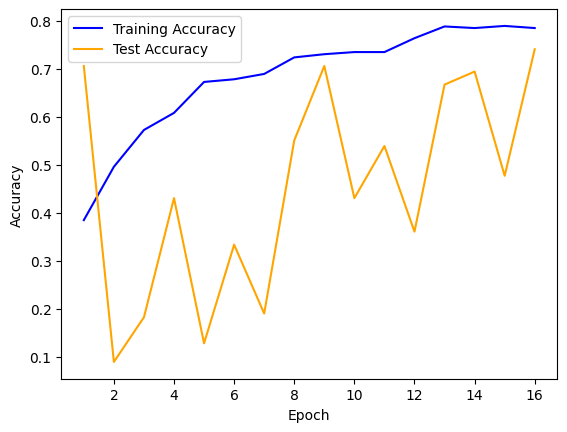

In [59]:
# Visualize the training and test accuracy metrices.
plt.plot(
    range(1,best_epochs_LRCN+1), 
    model.history.history['accuracy'],
    'blue', 
    label=f'Training Accuracy'
)
plt.plot(
    range(1,best_epochs_LRCN+1),
    model.history.history['val_accuracy'],
    'orange', 
    label=f'Test Accuracy'
)

# Add legend to the plot
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

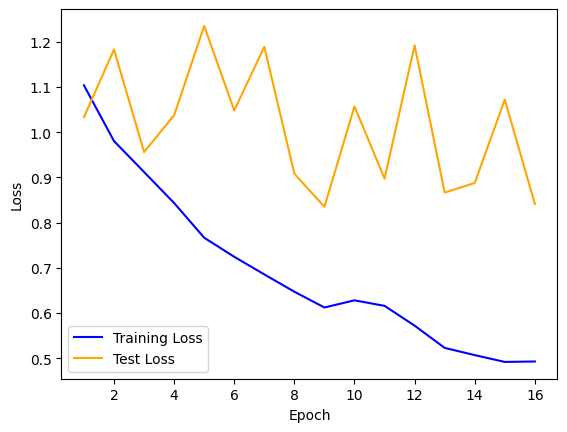

In [60]:
# Visualize the training and test loss metrices.
plt.plot(
    range(1,best_epochs_LRCN+1), 
    model.history.history['loss'],
    'blue', 
    label=f'Training Loss'
)
plt.plot(
    range(1,best_epochs_LRCN+1), 
    model.history.history['val_loss'],
    'orange', 
    label=f'Test Loss'
)

# Add legend to the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

9/9 [==============================] - 3s 67ms/step


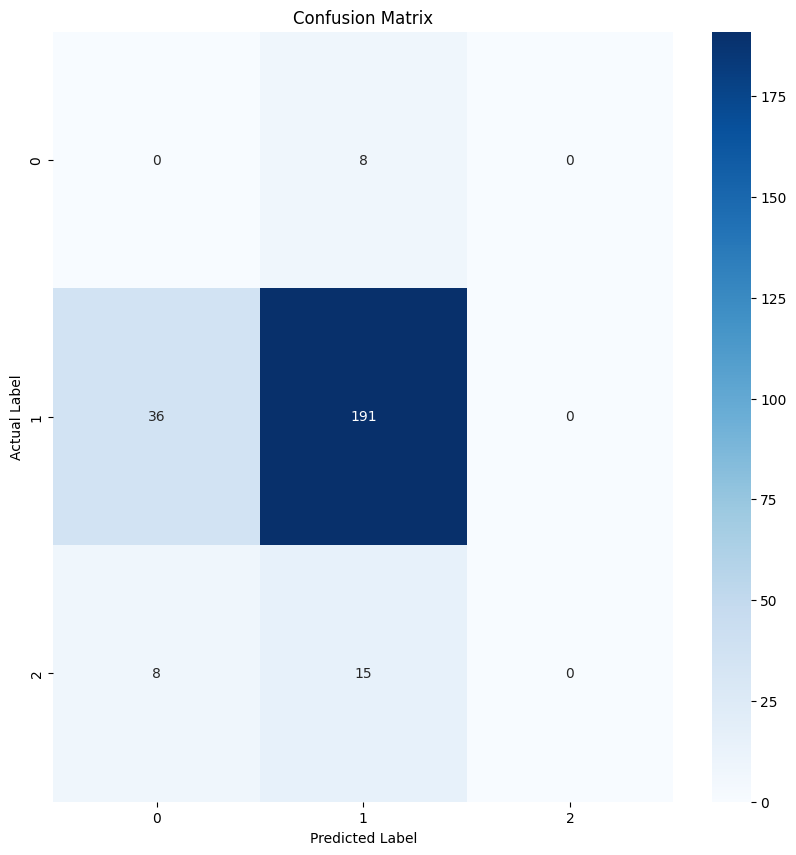

Accuracy: 0.74

Class-wise evaluation metrics:
Class          Precision Recall    F1-Score  Support   
hand_shaking   0.00      0.00      0.00      8         
nothing        0.89      0.84      0.87      227       
moving_arms    0.00      0.00      0.00      23        


In [61]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# Generate predictions on the test set
predicted_labels = model.predict(test_features)
predicted_labels = np.argmax(predicted_labels, axis=1)  # Convert probabilities to class labels

true_labels = np.argmax(labels_test_one_hot, axis=1)  # Convert one-hot encoded labels back to class labels
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}\n")
print("Class-wise evaluation metrics:")
print(f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'Support':<10}")
for i, class_label in enumerate(CLASSES_LIST):
    print(f"{class_label:<15}{precision[i]:<10.2f}{recall[i]:<10.2f}{f1_score[i]:<10.2f}{support[i]:<10}")